# Assignment 3: Linear Regression

Only use the already imported library `numpy` and the Python standard library. Make sure that the datasets `dataLinReg2D.txt`, `dataQuadReg2D.txt`, `dataQuadReg2D_noisy.txt` and `airfoil_self_noise.dat` are in the same directory as the notebook.

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

<h3>

Min Wang 3440557

Sisi Miao 3377882
    
Dominik Sellenthin 2836308   
    
</h3>

We are Master students.


## Task 1: Ridge Regression for Polynomial 2D Functions

Each line in the data sets consists of a data entry `(x,y)` with a 2D point `x` and a 1D function output `y`.

In [39]:
# Load required packages and datasets. Do not modify.
import numpy as np


def load_dataset(path):
    data = np.loadtxt(path)
    X, y = data[:, :2], data[:, 2]
    
    return X, y
    

X_lin, y_lin = load_dataset("dataLinReg2D.txt")
X_quad, y_quad = load_dataset("dataQuadReg2D.txt")
X_noise, y_noise = load_dataset("dataQuadReg2D_noisy.txt")




1) Extend the `make_features` method to also compute quadratic features (`ftype = 'quad'`). You may also experiment with other feature transformations, e.g. third-order polynomials.

In [40]:
def make_features(X, ftype='lin'):
    n, d = X.shape
    
    if ftype == 'lin': # Linear feature transformation (including intercept)
        Phi = np.empty((n, d+1))
        Phi[:, 0] = 1
        Phi[:, 1:] = X
        
    elif ftype == 'quad':  # Quadratic feature transformation
        # Implement for task 1.1.
        Phi_linear = np.hstack((np.ones((n, 1)), X))
        
        res=np.zeros((n, np.sum(range(d+1))))
        k=0
        #quad part
        for i in range(d):
            for j in range(i,d):
                res[:,k]=np.multiply(X[:,i], X[:,j])  
                k+=1
                
        Phi = np.hstack((Phi_linear,res))
        
    
    elif ftype == 'nasa':
        # Implement for task 2.2.
        
        from sklearn.preprocessing import PolynomialFeatures
        poly = PolynomialFeatures(4)
        poly_fit=poly.fit_transform(X)
        Phi = np.hstack((poly_fit,np.tanh(X)))

        
    
    else:
        raise Exception('Feature type {} not implemented yet'.format(ftype))
    
    return Phi

2) Implement Ridge Regression to fit a polynomial function to the data sets with the regularization parameter `lambda_` and feature type `ftype`.

Fill out the methods in `RidgeRegression` to train (`fit`) and predict (`predict`). Feel free to introduce new fields and methods based on your needs, but the methods `fit` and `predict` are required and their interface should not be changed. You need to store the vector of regression coefficients in the field `self.beta`.

In [41]:
# Implement your solution here.


class RidgeRegression(object):
    def __init__(self, lambda_, ftype = 'lin'):
        self.lambda_ = lambda_
        self.ftype = ftype
        self.beta = None  # Learned regression coefficients.
        

    
    
    def fit(self, X, y):
        """
        X is an array of shape (n, d), 
            where n is the number of samples and d is the number of features.
        y is an array of shape (n,)
        """
        self.X=X
        self.y=y
        
        
        Phi = make_features(X, self.ftype)
        
        # Implement your solution here.
        self.beta = np.zeros(Phi.shape[1])
        #print('self.beta',self.beta )
        
        xTx = np.matmul(Phi.T,Phi)
        xTx_ridge = xTx + np.identity(np.shape(Phi)[1])*self.lambda_
        if np.linalg.det(xTx_ridge) == 0.0:
            print("This matrix is singular, cannot do inverse") 
            
        self.beta = np.matmul(np.linalg.inv(xTx_ridge),np.dot(Phi.T,y)) 

        
        return self.beta
    
    def predict(self, X):
        """
        X is an array with shape (n, d).
        The method returns an array of shape (n,).
        """
        Phi = make_features(X, self.ftype)
        
        # Implement your solution here.
        y_pred = np.dot(Phi, self.beta.T)
        
        
        return y_pred
    

  
    def ridge_diff_lambda(self,X,y):
        
        #test this over a number of lambda values
        # 

        Phi = make_features(X, self.ftype)
        
        numTestPts = 20   #number of different lambda

        wMat = np.zeros((numTestPts,np.shape(Phi)[1]))#store all the beta from different lambda
        diff_lambda_=np.zeros(numTestPts)
        error_MSE=np.zeros(numTestPts)
        
        for i in range(numTestPts):
            self.lambda_= np.exp((i-10))
            diff_lambda_[i]=self.lambda_
            
            self.beta = self.fit(X,y)
            wMat[i,:]=self.beta.T
            
            yhat=self.predict(X)
            error_MSE[i] = MSE(yhat, y)
   

        return diff_lambda_,error_MSE,wMat

    

3) Implement the function `MSE` to compute the mean squared error. `y_pred` and `y_true` are the vectors of predicted and true function outputs respectively with shape `(n,)`, where `n` is the number of samples. The function returns a single float.

In [42]:
def MSE(y_pred, y_true):
    # Implement your solution here.
    error=np.square(np.subtract(y_pred, y_true)).mean()
    return error

4) Evaluate your Ridge Regression model with linear features on the linear `(X_lin, y_lin)` data set. Try to find a good `lambda_`. How does it perform with quadratic features on this data set? Report the MSE on the full data set when trained on the full data set. (Ideally, repeat this for different Ridge regularization parameters `lambda_` and generate a nice bar plot of the MSE for various `lambda_`.)

In [43]:
def train_evaluate(regression_model, X, y):
    beta=regression_model.fit(X, y)
    yhat = regression_model.predict(X)
    error_MSE = MSE(yhat, y)
    print('MSE:',error_MSE)

    
def plot_data_and_model(regression_model, X, y):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d.axes3d import Axes3D
    %matplotlib notebook
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(X[:, 0], X[:, 1], y, marker = 'o')
    
    xmin = X.min(0)
    xmax = X.max(0)

    x0grid, x1grid = np.mgrid[xmin[0]:xmax[0]:.3, xmin[1]:xmax[1]:.3]

    xdim0, xdim1 = np.shape(x0grid)
    xsize = np.size(x0grid)

    x0hat = x0grid.flatten()
    x1hat = x1grid.flatten()
    x0hat = x0hat.reshape((np.size(x0hat), 1))
    x1hat = x1hat.reshape((np.size(x1hat), 1))
    xhat = np.append(x0hat, x1hat, 1)
    xhatfv = make_features(xhat, regression_model.ftype)
    yhat = xhatfv.dot(regression_model.beta)
    ygrid = yhat.reshape((xdim0, xdim1))
    ax.plot_wireframe(x0grid, x1grid, ygrid)
    ax.auto_scale_xyz([xmin[0], xmax[0]], [xmin[1], xmax[1]], [y.min(), y.max()])
    fig.show()

    

# If the plot doesn't show the first time, run this cell again

Linear:
MSE: 0.010251108682211331


<IPython.core.display.Javascript object>


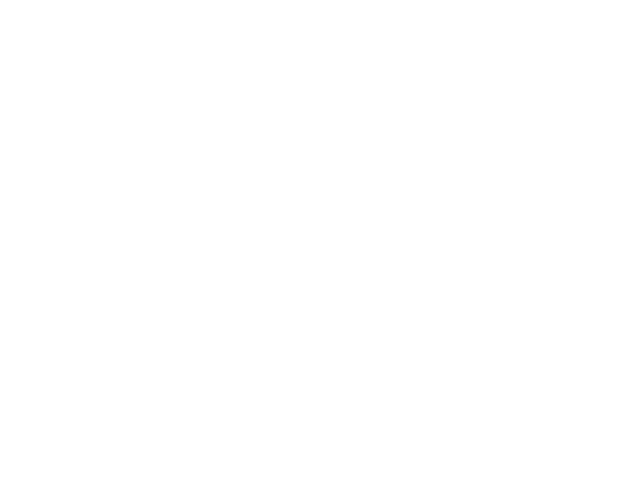

error_MSE_lin) [0.01024798 0.01024798 0.01024798 0.01024798 0.01024798 0.010248
 0.01024809 0.01024876 0.0102537  0.01029    0.01055329 0.01240467
 0.02442211 0.08891439 0.32505876 0.80710791 1.32482446 1.6576923
 1.81480549 1.87870675]


<IPython.core.display.Javascript object>


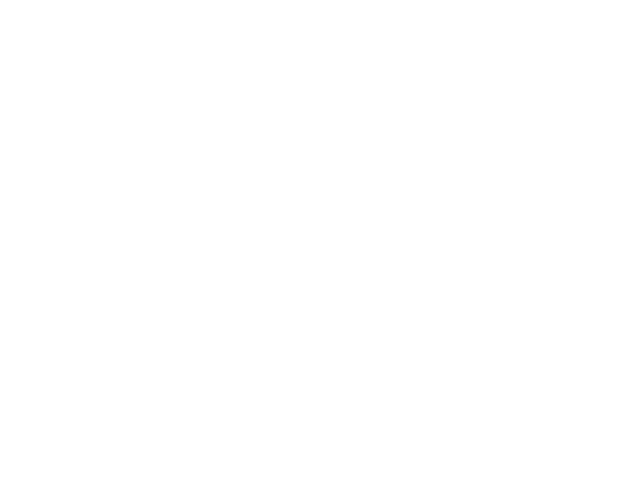

<IPython.core.display.Javascript object>


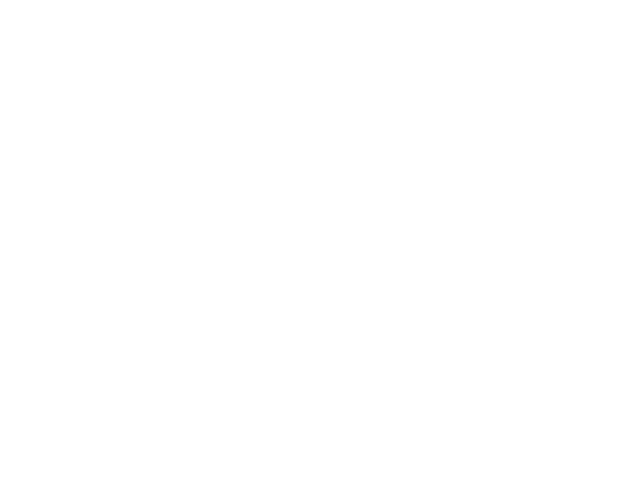

In [44]:
import matplotlib.pyplot as plt 


# Implement your solution here.  
print("Linear:")
regression_lin = RidgeRegression(lambda_=0.1, ftype='lin')
train_evaluate(regression_lin, X_lin, y_lin)
plot_data_and_model(regression_lin, X_lin, y_lin)


#linear for different lambda
diff_lambda_lin,error_MSE_lin,ridgeWeights_lin=regression_lin.ridge_diff_lambda(X_lin, y_lin)
print('error_MSE_lin)',error_MSE_lin)

#shrinkage plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.log(diff_lambda_lin),ridgeWeights_lin)

plt.xlabel("log(lambda)") 
plt.ylabel("Beta") 
plt.title("linear shrinkage for different lambda") 
plt.show()

#bar plot 
fig = plt.figure()   
plt.bar(np.log(diff_lambda_lin),error_MSE_lin, color ='maroon') 
  
plt.xlabel("log(lambda)") 
plt.ylabel("Beta") 
plt.title("linear MSE for different lambda") 
plt.show() 

==> *Write your observations here and report your results.* (double klick here to edit)

From a book, the author said that if you plot the Regression coefficient values while using ridge regression, for very small values of \lambda the coefficients are the same as regular regression, where as for very large values of \lambda the regression coefficients shrink to 0. Somewhere in between these two extremes, you can find values that allow you to make better predictions.

However, I find that when the \lambda is small (which is similar to the regular regression), we also can get the better prediction (samller MSE), so it seems that I cannot find the meaning of using ridge regression for these data sets. I think I can just use the regular regression here. Maybe for other data sets which have lots of fetures than samples, we may need redge regression.

5) Try to find a good model (including features and suitable `lambda_` parameters) for the quadratic data set `(X_quad, y_quad)`. Report the MSE on the full data set when trained on the full data set.  (Ideally, repeat this for different Ridge regularization parameters `lambda_` and generate a nice bar plot of the MSE for various `lambda_`.) Also plot your predicted model using the method above `plot_data_and_model`.

quadic:
MSE: 0.01188515105185238


<IPython.core.display.Javascript object>


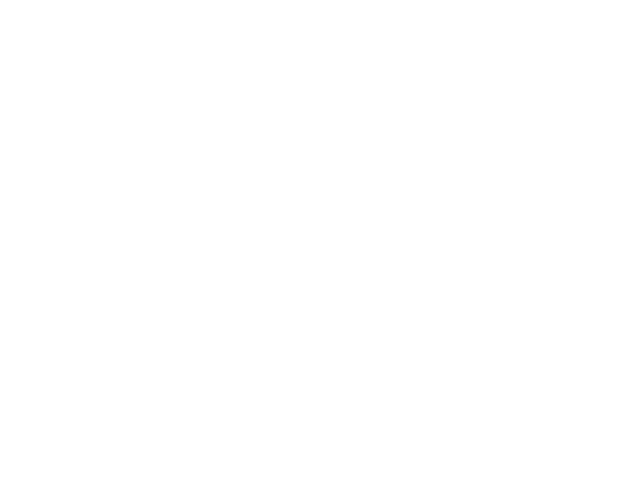

error_MSE_quad) [1.18828086e-02 1.18828086e-02 1.18828086e-02 1.18828088e-02
 1.18828100e-02 1.18828192e-02 1.18828873e-02 1.18833898e-02
 1.18870962e-02 1.19143577e-02 1.21133201e-02 1.35363972e-02
 2.32287190e-02 8.28844910e-02 3.96595495e-01 1.75423102e+00
 6.01278800e+00 1.36841110e+01 2.10086282e+01 2.53102396e+01]


<IPython.core.display.Javascript object>


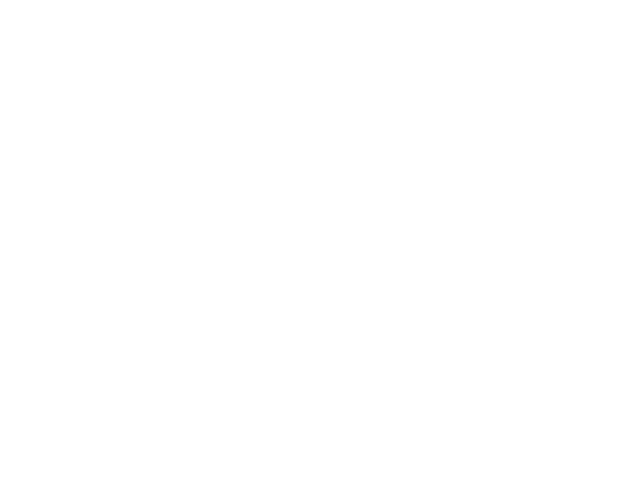

<IPython.core.display.Javascript object>


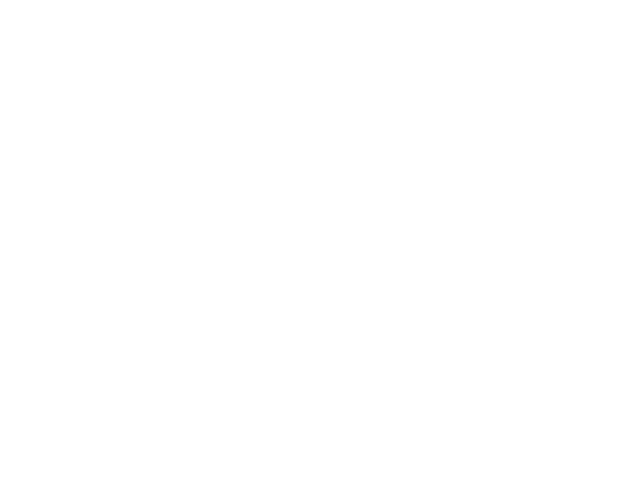

In [45]:
import matplotlib.pyplot as plt 
# Implement your model tests here using the quadratic data set
 
print("quadic:")
regression_quad = RidgeRegression(lambda_=0.1, ftype='quad')
train_evaluate(regression_quad, X_quad, y_quad)
plot_data_and_model(regression_quad, X_quad, y_quad)


#linear for different lambda
diff_lambda_quad,error_MSE_quad,ridgeWeights_quad=regression_quad.ridge_diff_lambda(X_quad, y_quad)
print('error_MSE_quad)',error_MSE_quad)

#shrinkage plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.log(diff_lambda_quad),ridgeWeights_quad)

plt.xlabel("log(lambda)") 
plt.ylabel("Beta") 
plt.title("_quad shrinkage for different lambda") 
plt.show()

#bar plot 
fig = plt.figure()   
plt.bar(np.log(diff_lambda_quad),error_MSE_quad, color ='maroon') 
  
plt.xlabel("log(lambda)") 
plt.ylabel("Beta") 
plt.title("quad MSE for different lambda") 
plt.show() 

==> *Write your observations here and report your results.* (double klick here to edit)

same as linear observations

From a book, the author said that if you plot the Regression coefficient values while using ridge regression, for very small values of \lambda the coefficients are the same as regular regression, where as for very large values of \lambda the regression coefficients shrink to 0. Somewhere in between these two extremes, you can find values that allow you to make better predictions.

However, I find that when the \lambda is small (which is similar to the regular regression), we also can get the better prediction (samller MSE), so it seems that I cannot find the meaning of using ridge regression for these data sets. I think I can just use the regular regression here. Maybe for other data sets which have lots of fetures than samples, we may need redge regression.


6) Try to find a good model (including features and suitable `lambda_` parameters) for the noisy data set `(X_noise, y_noise)`. Report the MSE on the full data set when trained on the full data set.  (Ideally, repeat this for different Ridge regularization parameters `lambda_` and generate a nice bar plot of the MSE for various `lambda_`.) Also plot your predicted model using the method above `plot_data_and_model`.

noise Linear:
MSE: 39.9552557016624


<IPython.core.display.Javascript object>


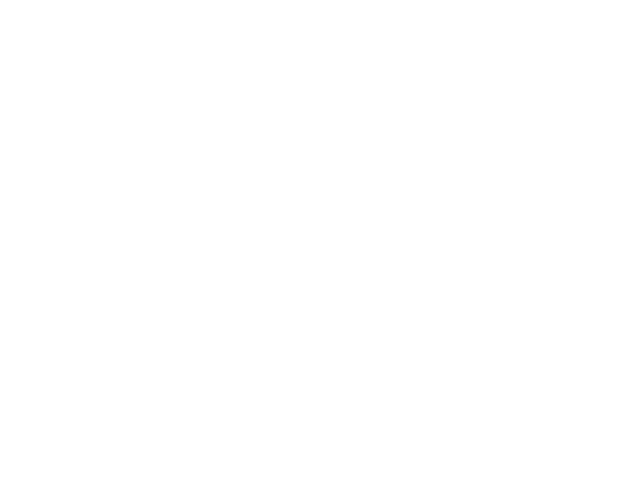

error_MSE_noise_lin) [39.95522635 39.95522635 39.95522635 39.95522635 39.95522637 39.95522648
 39.95522734 39.95523364 39.95528003 39.95561922 39.95805553 39.9747565
 40.07665529 40.5561684  41.96204316 44.13254745 45.93720014 46.91386749
 47.33568609 47.50081188]


<IPython.core.display.Javascript object>


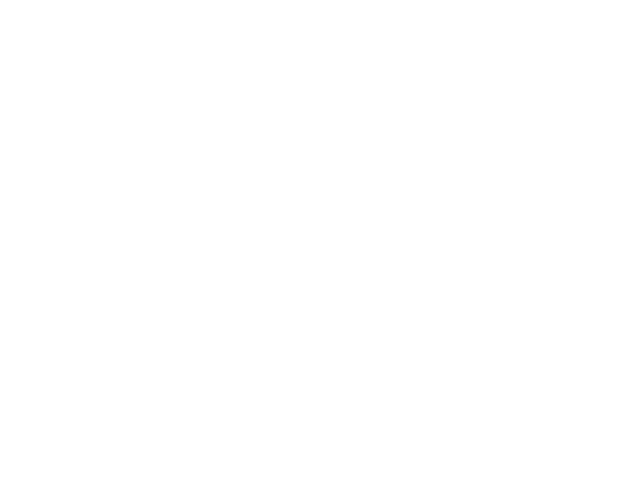

<IPython.core.display.Javascript object>


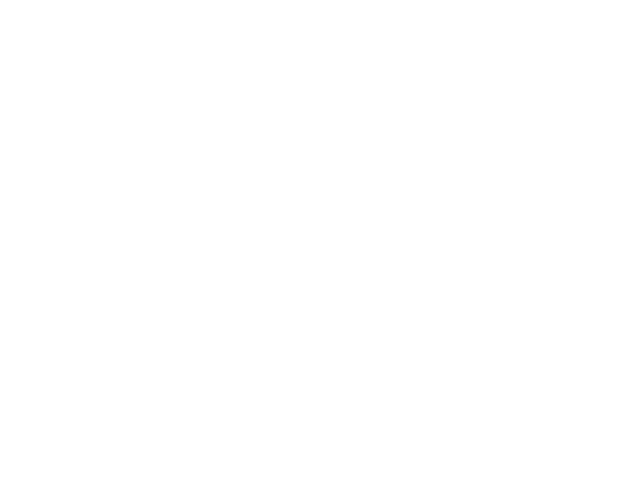

In [46]:
# Implement your model tests here using the noisy data set



import matplotlib.pyplot as plt 


# Implement your solution here.  
print("noise Linear:")
regression_noise_lin = RidgeRegression(lambda_=0.1, ftype='lin')
train_evaluate(regression_noise_lin, X_noise, y_noise)
plot_data_and_model(regression_noise_lin, X_noise, y_noise)


#linear for different lambda
diff_lambda_noise_lin,error_MSE_noise_lin,ridgeWeights_noise_lin=regression_noise_lin.ridge_diff_lambda(X_noise, y_noise)
print('error_MSE_noise_lin)',error_MSE_noise_lin)

#shrinkage plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.log(diff_lambda_noise_lin),ridgeWeights_noise_lin)

plt.xlabel("log(lambda)") 
plt.ylabel("Beta") 
plt.title("noise linear shrinkage for different lambda") 
plt.show()

#bar plot 
fig = plt.figure()   
plt.bar(np.log(diff_lambda_noise_lin),error_MSE_noise_lin, color ='maroon') 
  
plt.xlabel("log(lambda)") 
plt.ylabel("Beta") 
plt.title("noise linear MSE for different lambda") 
plt.show() 

noise quad:
MSE: 28.057854169355238


<IPython.core.display.Javascript object>


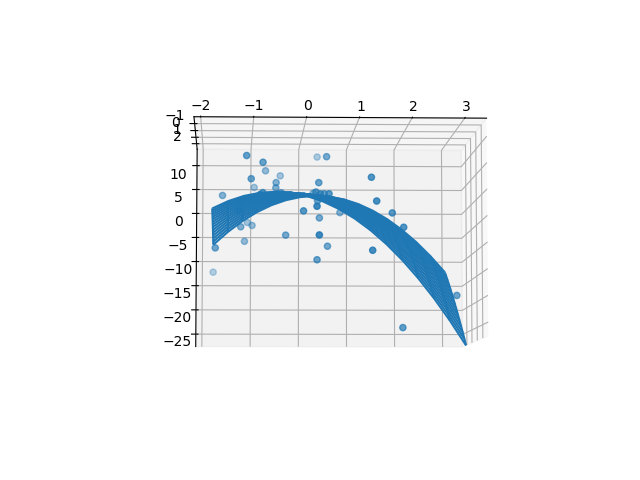

error_MSE_noise_quad) [28.05781176 28.05781176 28.05781176 28.05781177 28.05781179 28.05781196
 28.0578132  28.05782231 28.05788923 28.05837442 28.061784   28.08392799
 28.20445245 28.68655476 30.06364119 33.15343348 38.02352395 42.6503621
 45.46458579 46.76115315]


<IPython.core.display.Javascript object>


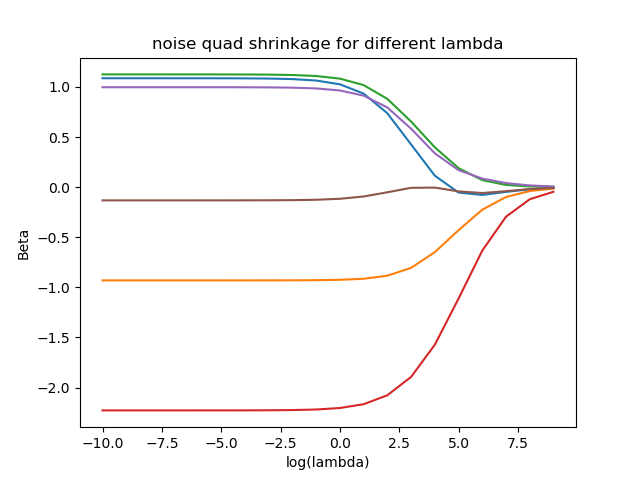

<IPython.core.display.Javascript object>


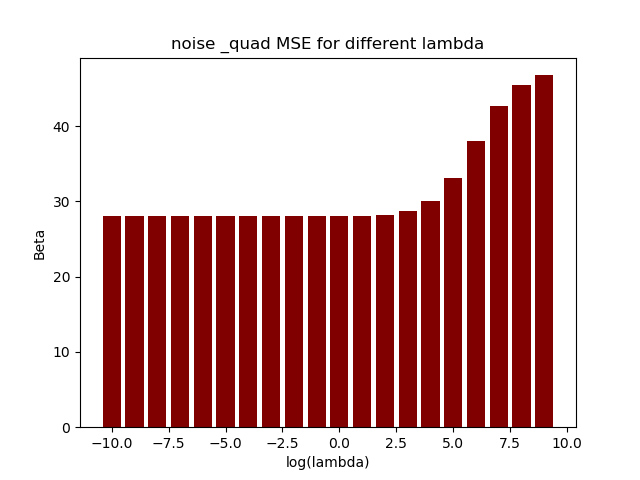

In [47]:
# Implement your model tests here using the noisy data set



import matplotlib.pyplot as plt 


# Implement your solution here.  
print("noise quad:")
regression_noise_quad = RidgeRegression(lambda_=0.1, ftype='quad')
train_evaluate(regression_noise_quad, X_noise, y_noise)
plot_data_and_model(regression_noise_quad, X_noise, y_noise)


#linear for different lambda
diff_lambda_noise_quad,error_MSE_noise_quad,ridgeWeights_noise_quad=regression_noise_quad.ridge_diff_lambda(X_noise, y_noise)
print('error_MSE_noise_quad)',error_MSE_noise_quad)

#shrinkage plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.log(diff_lambda_noise_quad),ridgeWeights_noise_quad)

plt.xlabel("log(lambda)") 
plt.ylabel("Beta") 
plt.title("noise quad shrinkage for different lambda") 
plt.show()

#bar plot 
fig = plt.figure()   
plt.bar(np.log(diff_lambda_noise_quad),error_MSE_noise_quad, color ='maroon') 
  
plt.xlabel("log(lambda)") 
plt.ylabel("Beta") 
plt.title("noise _quad MSE for different lambda") 
plt.show() 

==> *Write your observations here and report your results.* (double klick here to edit)

From pure observing the plots of the linear and quadratic regresseion, one can see that the quadratic plot fits the data (visually) better than the linear one. The linear regresseion yields a MSE of approximately 44 whereas the quadratic linear regression yields a MSE of approximately 28. So for the noisy data set, quadratic regression would be the preferred model instead of linear regression.

Also noticeable is the progress of the MSE with increasing lambda in both regressions, the linear and the quadratic. Up until log(lambda) ~ 2.5, the MSE is steady and does not decrease with decreasing lambda.

## Task 2: Airfoil Self-Noise Prediction

The air self-noise dataset is a [dataset by NASA](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise). Your task is to find a good feature mapping for ridge regression to achieve the lowest possible prediction error.

1) Explain the content of the dataset in few words. What are the input features? What is the output?

==> *Write your response here* (double klick here to edit)

The data set examines different airfoil behaviour in wind tunnels.

Five input features about attributes airfoils and Environment :
1. Frequency, in Hertzs.
2. Angle of attack, in degrees.
3. Chord length, in meters.
4. Free-stream velocity, in meters per second.
5. Suction side displacement thickness, in meters.

The only output is about self-noise:
6. Scaled sound pressure level, in decibels.

In [48]:
def load_dataset(path):
    data = np.genfromtxt(path)
    X, y = data[:, :5], data[:, 5]
    
    return X, y
    

X, y = load_dataset('airfoil_self_noise.csv')

2) Implement the option `ftype = 'nasa'` in the `make_features` function. You should try any type of non-linear features and interactions between features. You are not restricted to the feature mapping presented in the lecture. It is helpful to think about the domain and characteristics of the features, e.g. how do you work with periodic features.

Explain the choice of your features:

In [49]:
#feature scaling z-score normalization
def scale_z(X):
 
    X_scaled = np.divide(np.subtract(X, np.mean(X,axis=0)),np.std(X, axis=0))
    return X_scaled

X_scaled = scale_z(X)

==> *Briefly explain your chosen features.* (double klick here to edit)

3) Evaluate your Ridge Regression model with your chosen features on the data set. Try to find a good `lambda_`. Report the MSE on the full data set when trained on the full data set. (Ideally, repeat this for different Ridge regularization parameters `lambda_` and generate a nice bar plot of the MSE for various `lambda_`.)

In [50]:
def train_evaluate(regression_model, X, y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)
    
    regression_model.fit(X_train, y_train)
    yhat_test = regression_model.predict(X_test)
    print('MSE:', MSE(yhat_test, y_test))



NASA:
MSE: 7.895566383717669
error_MSE_nasa) [ 7.23952944  7.27657992  7.31615781  7.35422494  7.38876807  7.4230196
  7.4712086   7.54149669  7.6584891   7.84740407  8.05299839  8.23719926
  8.4298989   8.7181643   9.46562983 11.40785391 14.54648173 17.55537723
 19.60989772 20.80725943]


F:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


<IPython.core.display.Javascript object>


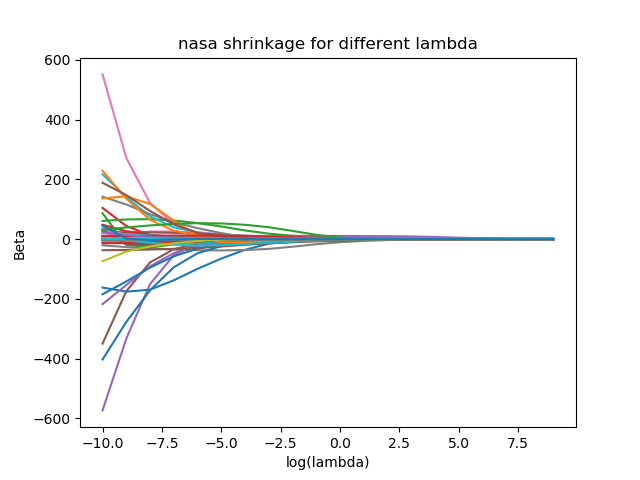

<IPython.core.display.Javascript object>


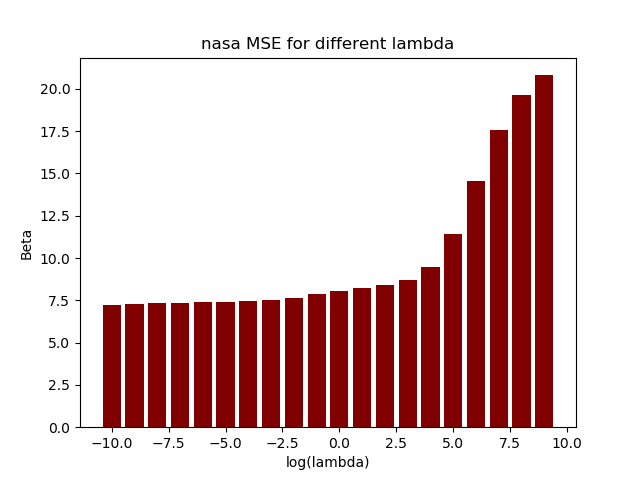

In [51]:
import matplotlib.pyplot as plt 


# Implement your solution here.  
print("NASA:")
your_regression = RidgeRegression(lambda_=0.1, ftype='nasa')
train_evaluate(your_regression, X, y)


#plot_data_and_model(your_regression, X, y)


# for different lambda
diff_lambda_nasa,error_MSE_nasa,ridgeWeights_nasa=your_regression.ridge_diff_lambda(X, y)
print('error_MSE_nasa)',error_MSE_nasa)

#shrinkage plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.log(diff_lambda_nasa),ridgeWeights_nasa)

plt.xlabel("log(lambda)") 
plt.ylabel("Beta") 
plt.title("nasa shrinkage for different lambda") 
plt.show()

#bar plot 
fig = plt.figure()   
plt.bar(np.log(diff_lambda_nasa),error_MSE_nasa, color ='maroon') 
  
plt.xlabel("log(lambda)") 
plt.ylabel("Beta") 
plt.title("nasa MSE for different lambda") 
plt.show() 

==> *Write your observations here and report your results.* (double klick here to edit)

Similar to what we found in the previous tasks, the MSE increases with increasing values for lambda. With the polynomial feature transformation, we can get the MSE to 7.895566383717669.

**For all students other than B.Sc. Data Science:**

4) Implement the function `cross_validation` to evaluate the prediction error of your model. Report the mean squared error from cross-validation. (Ideally, repeat this for different Ridge regularization parameters `lambda_` and generate a nice bar plot of the MSE for various `lambda_`.)

In [52]:
def cross_validation(regression_model, X, y,k=10):

    # Implement your solution here.


    sample_size = X.shape[0]
    subset_size = int(X.shape[0] / k)

    indices = np.arange(sample_size)#create indices of sample and make them randomly
    np.random.shuffle(indices)#shuffle indice instead of data, so we don't need to combine and sperate X and y
    
    MSE_cv = np.zeros(k)

    
    #split the random indice array and get the train data and test data
    for i in range(k):#k fold
    
        X_test = X[indices[i*subset_size:(i+1)*subset_size], :] 
        y_test = y[indices[i*subset_size:(i+1)*subset_size]]


        X_train = np.vstack((X[indices[:i*subset_size], :], X[indices[(i+1)*subset_size:], :])) 
        y_train = np.concatenate((y[indices[:i*subset_size]], y[indices[(i+1)*subset_size:]])) 
       
        
        regression_model.fit(X_train, y_train)
        yhat = regression_model.predict(X_test)
        MSE_cv[i] = MSE(yhat, y_test)
 
    MSE_cv_mean = MSE_cv.mean()
    print('MSE_cv',MSE_cv,'MSE_cv_mean',MSE_cv_mean)
    

    return MSE_cv_mean



In [53]:
#choose lambda

def choose_lambda(regression_model,X,y):
    np.random.seed(46) #set random seed so that we can easily compare the results of different solutions later.




    numTestPts = 20   #number of different lambda

 
    diff_lambda_cv=np.zeros(numTestPts)
    MSE_cv=np.zeros(numTestPts)
        
    for i in range(numTestPts):
        regression_model.lambda_= np.exp((i-10))

        diff_lambda_cv[i]=regression_model.lambda_
        MSE_cv[i] =  cross_validation(regression_model, X, y)


    return diff_lambda_cv,MSE_cv
   

    



NASA:
MSE_cv [ 6.51005844  7.82212626 12.03190025  7.81673964  8.35656425  5.41731379
  9.06061299  7.32756761 13.77680323 12.72675544] MSE_cv_mean 9.084644189730174
MSE_cv [10.46535447 10.65233962  9.60922683  8.19880963  8.73476555 10.73377741
 10.31958437 11.72581881  6.17235727  8.32699765] MSE_cv_mean 9.493903160350865
MSE_cv [ 5.92925658 10.02448093  9.46362417  7.45994726 13.45313383  7.87447834
 10.56808784  8.50959466 11.71001646  7.18108015] MSE_cv_mean 9.217370021088207


F:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


MSE_cv [ 7.34604461 15.43326483  7.11089921  9.56892872  9.68276889 11.13536133
 11.93490917  6.77415935  8.16891309  6.57142903] MSE_cv_mean 9.372667822004642
MSE_cv [10.58142327  8.73240734  9.70403652 11.20070181  7.06033555 10.62322109
  9.50076569  6.06672322  6.2702836  12.58364201] MSE_cv_mean 9.232354010548894
MSE_cv [11.44859854  8.71396441 15.38350419  9.56430373  8.54263949 10.21618732
  7.70460597  8.17250556  9.68345321  8.42766079] MSE_cv_mean 9.785742319902273
MSE_cv [ 9.80891361 10.35247823  9.70092183  6.64363738 11.21140945  6.66596326
 10.84139057  9.19109276  9.87463207  9.17181149] MSE_cv_mean 9.346225064972066
MSE_cv [ 9.39644093  8.35360706  7.45774613 23.54941051  8.2084718   8.96909311
  7.57898691  8.92294819  9.17227134 12.15664392] MSE_cv_mean 10.376561990299134
MSE_cv [10.07241071  7.95501172  9.13470068 11.33097099 11.64860655  7.24381287
 16.369309    9.06989863  6.67346194  7.79293126] MSE_cv_mean 9.729111435003423
MSE_cv [18.92589201  7.25139917  8.8476

<IPython.core.display.Javascript object>


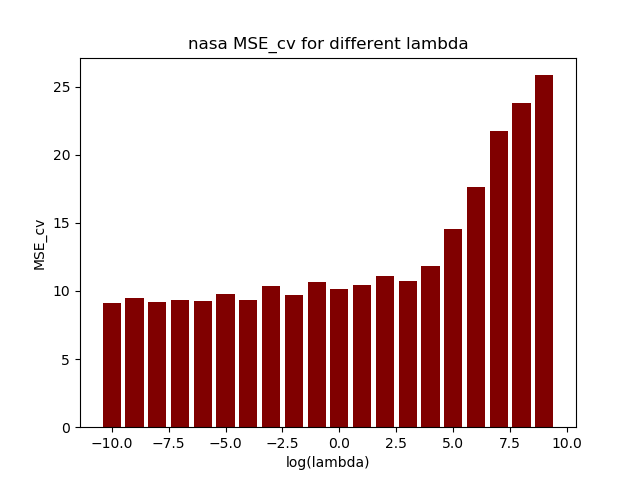

In [54]:


print("NASA:")
your_regression = RidgeRegression(lambda_=0.1, ftype='nasa')
diff_lambda_cv,MSE_cv=choose_lambda(your_regression,X,y)



#bar plot 
fig = plt.figure()   
plt.bar(np.log(diff_lambda_cv),MSE_cv, color ='maroon') 
  
plt.xlabel("log(lambda)") 
plt.ylabel("MSE_cv") 
plt.title("nasa MSE_cv for different lambda") 
plt.show() 

==> *Write your observations here and report your results.* (double klick here to edit)

Unlike the other MSE plots, the MSE gets bigger and smaller with increasing lambda, see for example progression from log(lambda) ~ -3 to log(lambda) ~ 3 with an MSE of roughly 10.